In [1]:
import sys
import pprint
import os
import numpy as np
import keras
from keras.utils.np_utils import to_categorical
import h5py
import yaml, json
from PIL import Image
%pylab inline
plt.rcParams['image.cmap'] = 'gray'

# get magic root folder
config_path="/work/ds_config.yaml"
with open(config_path) as f:
    configs = yaml.safe_load(f)
sys.path.append(configs['PROJECT_ROOT'])


from data_iters import hdf5_iterator

Populating the interactive namespace from numpy and matplotlib


In [2]:
import theano
theano.config.exception_verbosity='high'
theano.config.optimizer='fast_compile'

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, AutoEncoder
from keras.layers.convolutional import MaxPooling2D, Convolution2D, Convolution1D

from keras.optimizers import SGD, Adam

from stn.attention import SpatialTransformer

Using Theano backend.


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled)


In [3]:
#data
nb_authors = 100
nb_forms = 8
shingle_dim = (128,128)
iam_iter = hdf5_iterator.Hdf5MiniBatcher("/fileserver/iam/iam-processed/lines/author_lines.hdf5",
                                            nb_authors,
                                            nb_forms,
                                            shingle_dim=shingle_dim)

In [4]:
# initial weights
batch_size = 256
epoch_size = 1000

b = np.zeros((2, 3), dtype='float32')
b[0, 0] = 1
b[1, 1] = 1
W = np.zeros((50, 6), dtype='float32')
weights = [W, b.flatten()]

input_shape = (1,128,128)

# from seya's STN demo notebook:
locnet = Sequential()
locnet.add(MaxPooling2D(pool_size=(4,4), input_shape=input_shape))
locnet.add(Convolution2D(20, 4, 4))
locnet.add(MaxPooling2D(pool_size=(2,2)))
locnet.add(Convolution2D(20, 4, 4))

locnet.add(Flatten(input_shape=input_shape))
locnet.add(Dense(50))
locnet.add(Activation('relu'))
locnet.add(Dense(6, weights=weights))

In [5]:
model = Sequential()
model.add(SpatialTransformer(locnet, input_shape=input_shape,downsample_factor=4))
model.add(Convolution2D(32, 4, 4, border_mode='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(8, 8)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dense(nb_authors))
model.add(Activation('softmax'))

adam = Adam(lr=0.0001)

model.compile(loss='categorical_crossentropy', optimizer=adam)

In [6]:
# allows visualizing STN output
XX = model.get_input()
YY = model.layers[0].get_output()
F = theano.function([XX], YY)

pprint.pprint(locnet.get_config())
pprint.pprint(model.get_config())

{'layers': [{'border_mode': 'valid',
             'cache_enabled': True,
             'dim_ordering': 'th',
             'input_shape': (1, 128, 128),
             'name': 'MaxPooling2D',
             'pool_size': (4, 4),
             'strides': (4, 4)},
            {'W_constraint': None,
             'W_regularizer': None,
             'activation': 'linear',
             'activity_regularizer': None,
             'b_constraint': None,
             'b_regularizer': None,
             'border_mode': 'valid',
             'cache_enabled': True,
             'dim_ordering': 'th',
             'init': 'glorot_uniform',
             'name': 'Convolution2D',
             'nb_col': 4,
             'nb_filter': 20,
             'nb_row': 4,
             'subsample': (1, 1)},
            {'border_mode': 'valid',
             'cache_enabled': True,
             'dim_ordering': 'th',
             'name': 'MaxPooling2D',
             'pool_size': (2, 2),
             'strides': (2, 2)},
         

----------------------------------------
Epoch: 0 | Train: 0.02734375


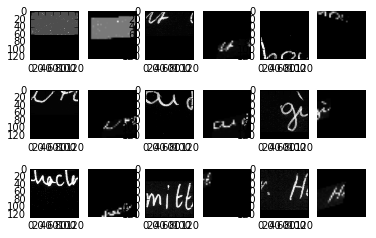

----------------------------------------


In [7]:
nb_epochs = 50 # you probably want to go longer than this

fig = plt.figure()
try:
    for e in range(nb_epochs):
        print('-'*40)
        #progbar = generic_utils.Progbar(X_train.shape[0])
        for b in range(epoch_size):
            f = b * batch_size
            l = (b+1) * batch_size
            [X_batch, y_batch] = iam_iter.get_train_batch(batch_size)
            # add an invisible dimension
            X_batch = np.expand_dims(X_batch, 1).astype('float32')
            y_batch = to_categorical(y_batch, nb_authors).astype('float32')
            loss = model.train_on_batch(X_batch, y_batch)
            #progbar.add(X_batch.shape[0], values=[("train loss", loss)])
        scoretr = model.evaluate(X_batch, y_batch, show_accuracy=True, verbose=0)[1]
        #scorev = model.evaluate(X_valid, y_valid, show_accuracy=True, verbose=0)[1]
        #scoret = model.evaluate(X_test, y_test, show_accuracy=True, verbose=0)[1]
        print('Epoch: {0} | Train: {1}'.format(e, scoretr))

        if e % 5 == 0:
            Xresult = F(X_batch[:9])
            plt.clf()
            for i in range(9):
                plt.subplot(3, 6, i*2+1)
                plt.imshow(X_batch[i, 0], cmap='gray')
                plt.subplot(3, 6, i*2+2)
                plt.imshow(Xresult[i, 0], cmap='gray')
                plt.axis('off')
            fig.canvas.draw()
            plt.show()
except KeyboardInterrupt:
    pass